# Medical JComp with Uterus Segmentation

In [ ]:
!pip install -q segmentation_models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp ./gdrive/MyDrive/CSE3042_JComp/images.zip ./
!cp ./gdrive/MyDrive/CSE3042_JComp/uterus_segmentation.h5 ./
!rm -rf images > /dev/null
!unzip ./images.zip > /dev/null

## Imports

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

In [ ]:
IMAGE_SIZE = (320,320)

## Load images

In [ ]:
# Normal uterus
normal = sorted(glob.glob("./images/normal/original/*.jpg"))
normal_uterus = sorted(glob.glob("./images/normal/uterus_mask/*.jpg"))
normal_endomet = sorted(glob.glob("./images/normal/endometrium_mask/*.jpg"))
normal_fibroid = sorted(glob.glob("./images/normal/fibroid_mask/*.jpg"))

# Uterus with fibroids
fibroid = sorted(glob.glob("./images/fibroid/original/*.jpg"))
fibroid_uterus = sorted(glob.glob("./images/fibroid/uterus_mask/*.jpg"))
fibroid_fibroid = sorted(glob.glob("./images/fibroid/fibroid_mask/*.jpg"))

# Uterus with Adenomyosis
adeno = sorted(glob.glob("./images/adenomyosis/original/*.jpg"))
adeno_uterus = sorted(glob.glob("./images/adenomyosis/uterus_mask/*.jpg"))
adeno_endomet = sorted(glob.glob("./images/adenomyosis/endometrium_mask/*.jpg"))
adeno_fibroid = sorted(glob.glob("./images/adenomyosis/fibroid_mask/*.jpg"))

In [ ]:
if len(normal) == len(normal_uterus) and len(normal) == len(normal_endomet) and len(normal) == len(normal_fibroid):
    print(f"Loaded {len(normal)} normal images")
else:
    print(f"Missing normal images {len(normal)=} {len(normal_uterus)=} {len(normal_endomet)=}")

if len(fibroid) == len(fibroid_fibroid) and len(fibroid) == len(fibroid_uterus) and len(fibroid) == len(fibroid_fibroid):
    print(f"Loaded {len(fibroid)} fibroid images")
else:
    print(f"Missing fibroid images {len(fibroid)=} {len(fibroid_fibroid)=} {len(fibroid_uterus)=}")

if len(adeno) == len(adeno_uterus) and len(adeno) == len(adeno_endomet) and len(adeno) == len(adeno_fibroid):
    print(f"Loaded {len(adeno)} fibroid images")
else:
    print(f"Missing fibroid images {len(adeno)=} {len(adeno_uterus)=} {len(adeno_endomet)=}")

Loaded 29 normal images
Loaded 44 fibroid images
Loaded 32 fibroid images


In [ ]:
def load_image_from_path(img_path: str, grayscale = True):
    """
    Load a grayscale, resized and normalized image from given path
    """
    img = Image.open(img_path)
    if grayscale:
        img = img.convert("L")
    img = img.resize(IMAGE_SIZE)
    img = np.array(img) / 255.0
    if grayscale:
        img = np.reshape(img, (*IMAGE_SIZE, 1))    
    else:
        img = np.reshape(img, (*IMAGE_SIZE, 3))    
    return img

def visualize_image_mask(image: np.ndarray, mask1: np.ndarray, mask2=None, mask3=None, image_title="Image", mask1_title="Mask 1", mask2_title="Mask 2",  mask3_title="Mask 3"):
    """
    Visualizes an image and its corresponding masks side-by-side.
    """
    cols = 2
    if mask2 is not None:
        cols = 3
    if mask3 is not None:
        cols = 4
    fig, ax = plt.subplots(1, cols, figsize=(cols*3, 5))
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title(image_title)
    ax[1].imshow(mask1, cmap="gray")
    ax[1].set_title(mask1_title)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    if mask2 is not None:
        ax[2].imshow(mask2, cmap="gray")
        ax[2].set_title(mask2_title)
        ax[2].set_xticks([])
        ax[2].set_yticks([])
    if mask3 is not None:
        ax[3].imshow(mask3, cmap="gray")
        ax[3].set_title(mask3_title)
        ax[3].set_xticks([])
        ax[3].set_yticks([])
    
    plt.show()

# Visualize some samples and masks

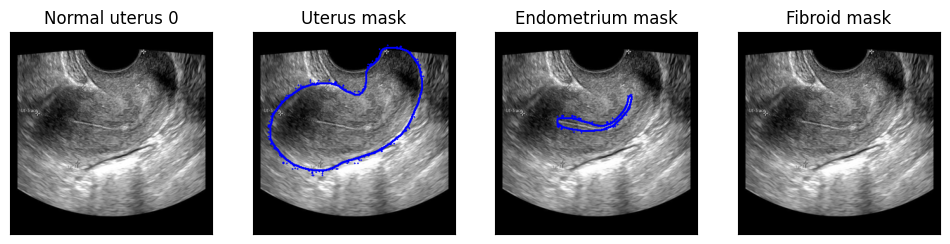

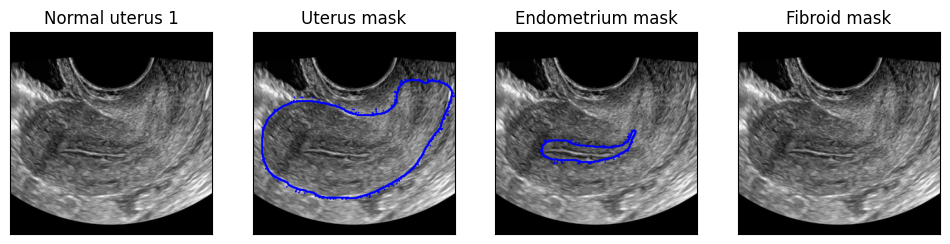

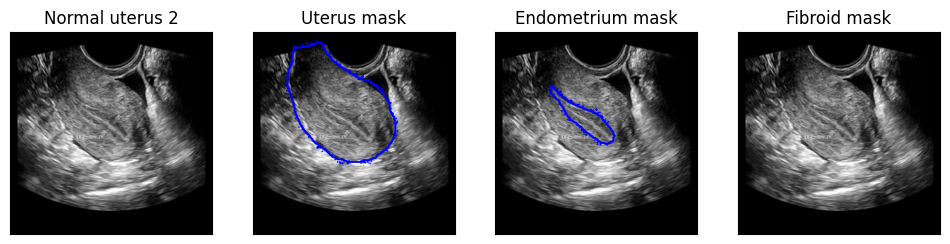

In [ ]:
import cv2

def draw_mask_outline(original_image, mask):
    """
    Draws a blue outline on the original image around the masked region.
    """
    original_image = (original_image * 255).astype(np.uint8)
    mask = (mask*255).astype(np.uint8)
    if original_image.shape[2] == 1:
        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
    else:
        original_image_rgb = original_image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(original_image_rgb, contours, -1, (0, 0, 255), 2)

    return original_image_rgb

for i in range(3):
    img1 = load_image_from_path(normal[i])
    img1_uterus = load_image_from_path(normal_uterus[i])
    img1_endomet = load_image_from_path(normal_endomet[i])
    img1_fibroid = load_image_from_path(normal_fibroid[i])
    visualize_image_mask(img1, draw_mask_outline(img1, img1_uterus), draw_mask_outline(img1, img1_endomet), draw_mask_outline(img1, img1_fibroid), image_title=f"Normal uterus {i}", mask1_title="Uterus mask", mask2_title="Endometrium mask", mask3_title="Fibroid mask")

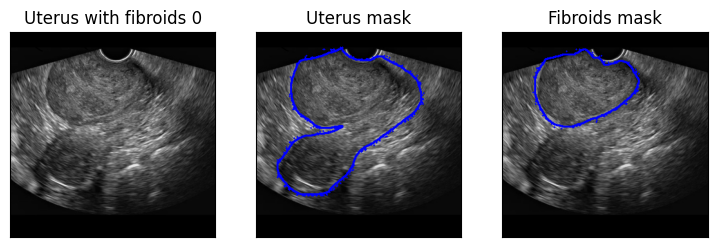

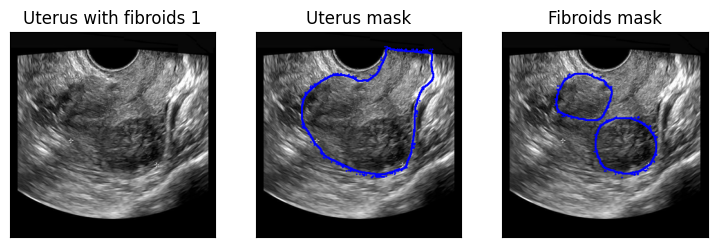

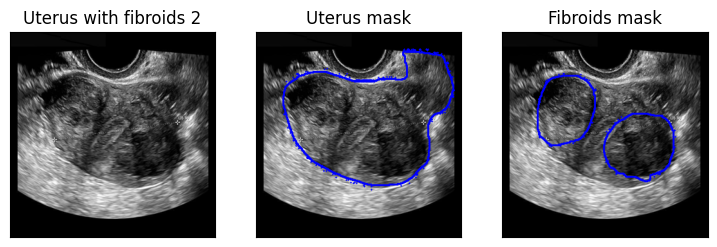

In [ ]:
for i in range(3):
    img1 = load_image_from_path(fibroid[i])
    img1_uterus = load_image_from_path(fibroid_uterus[i])
    img1_fibroid = load_image_from_path(fibroid_fibroid[i])
    visualize_image_mask(img1, draw_mask_outline(img1, img1_uterus), draw_mask_outline(img1, img1_fibroid), image_title=f"Uterus with fibroids {i}", mask1_title="Uterus mask", mask2_title="Fibroids mask")

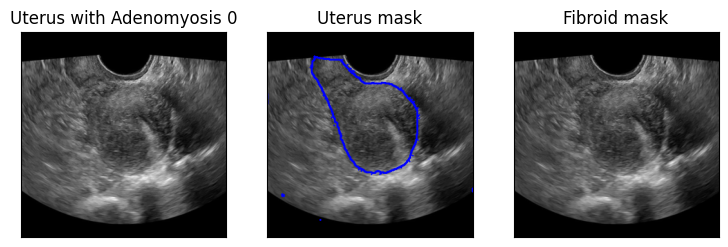

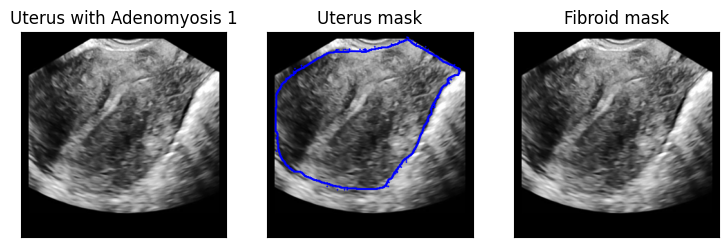

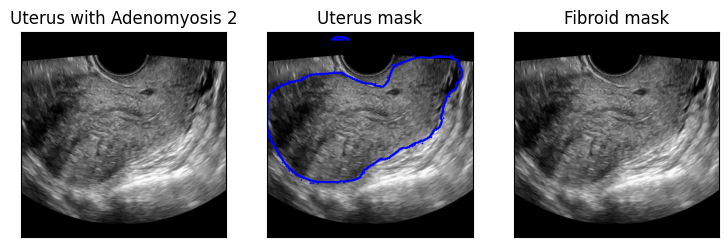

In [ ]:
for i in range(3):
    img1 = load_image_from_path(adeno[i])
    img1_uterus = load_image_from_path(adeno_uterus[i])
    img1_fibroid = load_image_from_path(adeno_fibroid[i])
    visualize_image_mask(img1, draw_mask_outline(img1, img1_uterus), draw_mask_outline(img1, img1_fibroid), image_title=f"Uterus with Adenomyosis {i}", mask1_title="Uterus mask", mask2_title="Fibroid mask")

In [ ]:
def load_and_split_images(img_paths, mask1_paths, mask2_paths, mask3_paths=None, test_size=0.2, random_state=None):
    """
    Loads images/masks from file paths, converts them into numpy arrays, and performs an 80-20 train-test split.
    """
    imgs = []
    for path in img_paths:
        image = load_image_from_path(path, False)
        imgs.append(image)

    # Load mask1 images
    mask1s = []
    for path in mask1_paths:
        image = load_image_from_path(path)
        mask1s.append(image)

    # Load mask2 images
    mask2s = []
    for path in mask2_paths:
        image = load_image_from_path(path)
        mask2s.append(image)
    
    mask3s = []
    if mask3_paths is not None:
        for path in mask3_paths:
            image = load_image_from_path(path)
            mask3s.append(image)

    imgs = np.array(imgs)
    mask1s = np.array(mask1s)
    mask2s = np.array(mask2s)
    mask3s = np.array(mask3s)

    img_train, img_test, mask1_train, mask1_test, mask2_train, mask2_test, mask3_train, mask3_test = train_test_split(imgs, mask1s, mask2s, mask3s, test_size=test_size, random_state=random_state)

    return img_train, img_test, mask1_train, mask1_test, mask2_train, mask2_test, mask3_train, mask3_test

## Load dataset

In [ ]:
normal_img_train, normal_img_test, normal_uterus_train, normal_uterus_test, normal_endomet_train, normal_endomet_test, normal_fibroid_train, normal_fibroid_test = load_and_split_images(normal, normal_uterus, normal_endomet, normal_fibroid, random_state=42)

In [ ]:
fibroid_img_train, fibroid_img_test, fibroid_uterus_train, fibroid_uterus_test, fibroid_fibroid_train, fibroid_fibroid_test, _, _ = load_and_split_images(fibroid, fibroid_uterus, fibroid_fibroid, fibroid_fibroid, random_state=42)

In [ ]:
adeno_img_train, adeno_img_test, adeno_uterus_train, adeno_uterus_test, adeno_endomet_train, adeno_endomet_test, adeno_fibroid_train, adeno_fibroid_test = load_and_split_images(adeno, adeno_uterus, adeno_endomet, adeno_fibroid, random_state=42)

## Generate dataset for uterus segmentation

In [ ]:
uterus_train = np.concatenate((normal_img_train, fibroid_img_train, adeno_img_train, normal_img_test, fibroid_img_test, adeno_img_test), axis=0)
uterus_mask_train = np.concatenate((normal_uterus_train, fibroid_uterus_train, adeno_uterus_train, normal_uterus_test, fibroid_uterus_test, adeno_uterus_test), axis=0)

uterus_test = np.concatenate((normal_img_test, fibroid_img_test, adeno_img_test), axis=0)
uterus_mask_test = np.concatenate((normal_uterus_test, fibroid_uterus_test, adeno_uterus_test), axis=0)

In [ ]:
uterus_train.shape, uterus_test.shape

((105, 320, 320, 3), (22, 320, 320, 3))

In [ ]:
uterus_mask_train.shape, uterus_mask_test.shape

((105, 320, 320, 1), (22, 320, 320, 1))

## Define U-net model for uterus segmentation

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Define U-Net model architecture
def unet(input_size=(*IMAGE_SIZE, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    
    # Output layer with sigmoid activation for binary segmentation
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model with binary cross-entropy loss and Adam optimizer
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=sm.losses.binary_focal_jaccard_loss,
        metrics=[sm.metrics.iou_score])
    # model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = unet()

In [ ]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  640         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_25 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_24[0][0]']              
                                )                                                          

In [ ]:
checkpoint = ModelCheckpoint('uterus_segmentation.h5', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(uterus_train, uterus_mask_train, batch_size=8, epochs=25, validation_data=(uterus_test, uterus_mask_test), callbacks=[checkpoint])

Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 0.8744 - iou_score: 0.2289
Epoch 1: val_loss improved from inf to 0.85006, saving model to uterus_segmentation.h5
11/11 [==============================] - 117s 7s/step - loss: 0.8744 - iou_score: 0.2289 - val_loss: 0.8501 - val_iou_score: 0.2480
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 0.8428 - iou_score: 0.2454
Epoch 2: val_loss improved from 0.85006 to 0.73739, saving model to uterus_segmentation.h5
11/11 [==============================] - 31s 3s/step - loss: 0.8428 - iou_score: 0.2454 - val_loss: 0.7374 - val_iou_score: 0.3202
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.8213 - iou_score: 0.2699
Epoch 3: val_loss did not improve from 0.73739
11/11 [==============================] - 29s 3s/step - loss: 0.8213 - iou_score: 0.2699 - val_loss: 0.7392 - val_iou_score: 0.3232
Epoch 4/25
11/11 [==============================] - ETA: 0s - loss: 0.7587 - iou_score: 0.3092
E

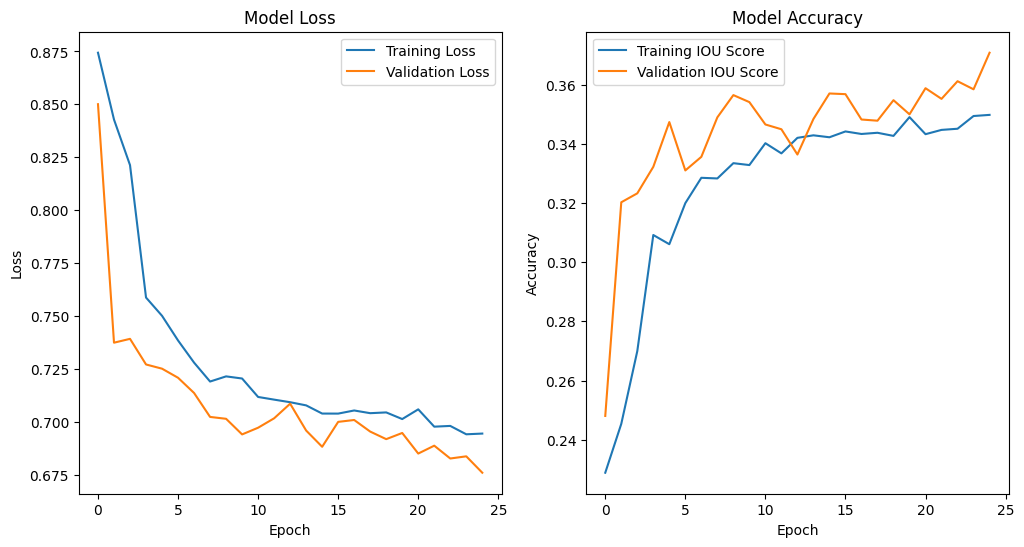

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['iou_score'], label='Training IOU Score')
plt.plot(history.history['val_iou_score'], label='Validation IOU Score')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.show()

In [ ]:
!cp ./uterus_segmentation.h5 /content/gdrive/MyDrive/CSE3042_JComp/

In [ ]:
# model = tf.keras.models.load_model('./uterus_segmentation.h5')

1/1 [==============================] - 0s 238ms/step


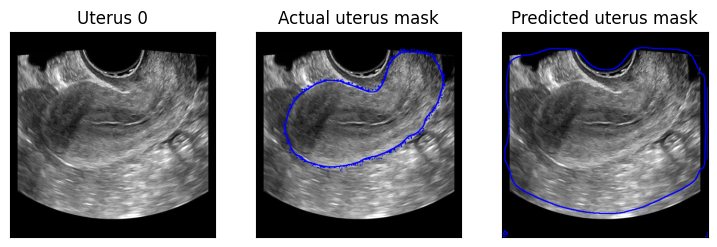

1/1 [==============================] - 0s 22ms/step


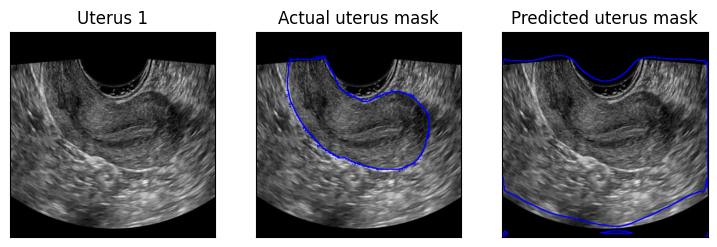

1/1 [==============================] - 0s 20ms/step


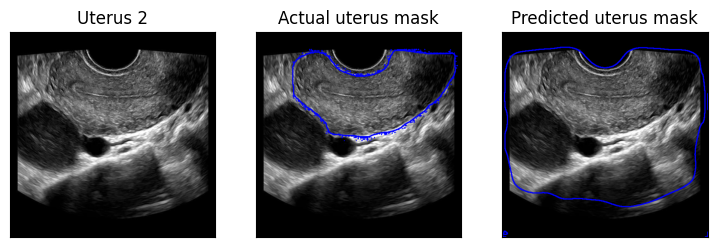

1/1 [==============================] - 0s 22ms/step


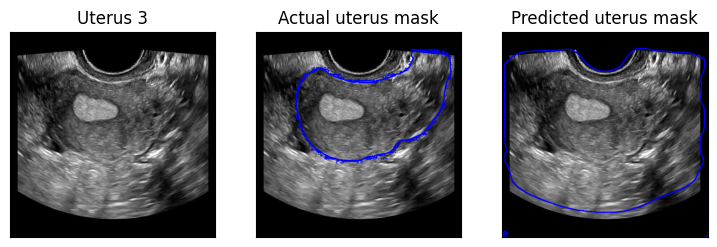

1/1 [==============================] - 0s 21ms/step


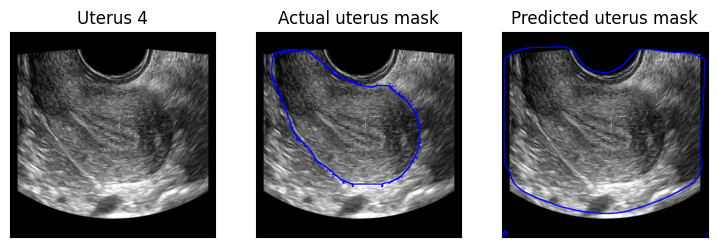

1/1 [==============================] - 0s 19ms/step


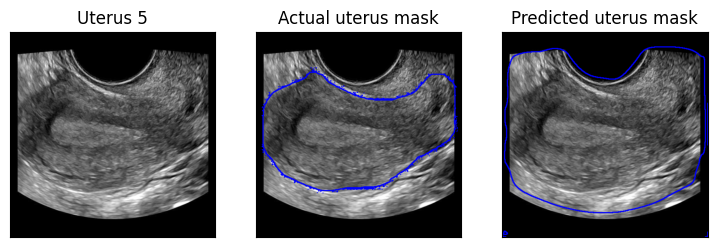

1/1 [==============================] - 0s 19ms/step


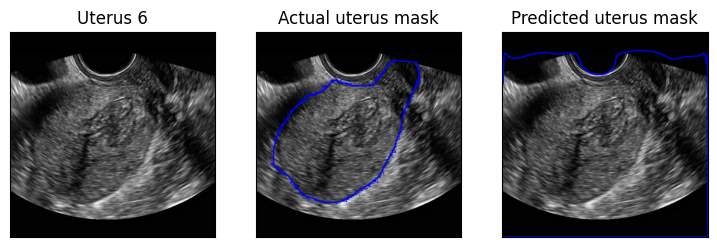

1/1 [==============================] - 0s 20ms/step


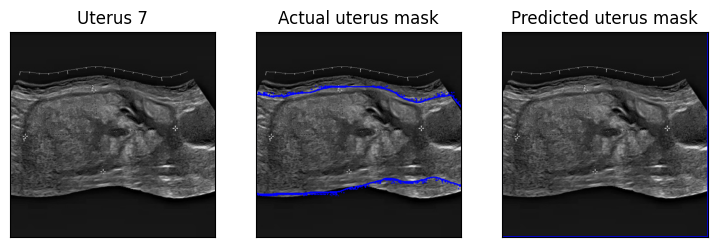

1/1 [==============================] - 0s 20ms/step


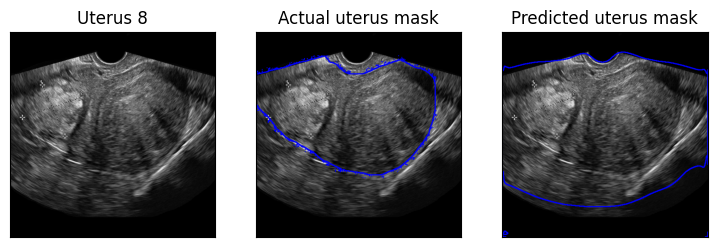

1/1 [==============================] - 0s 21ms/step


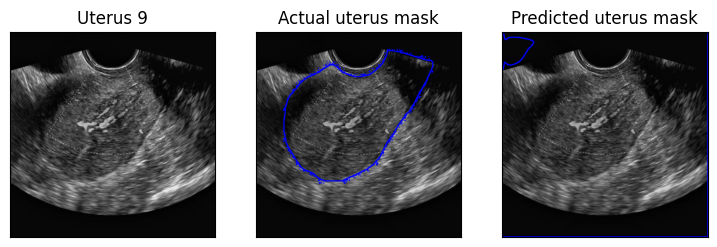

1/1 [==============================] - 0s 24ms/step


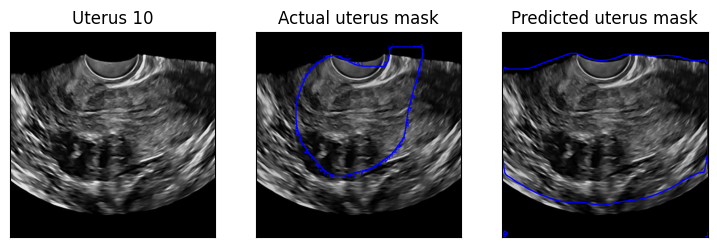

1/1 [==============================] - 0s 21ms/step


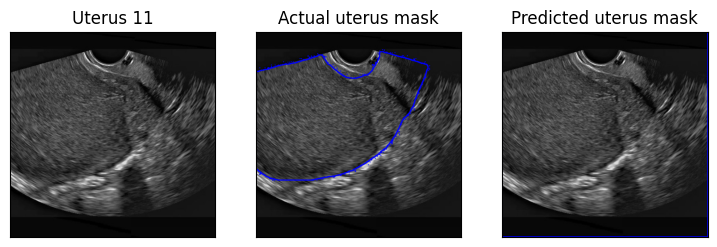

1/1 [==============================] - 0s 21ms/step


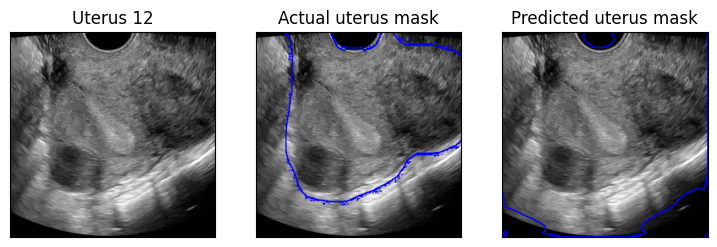

1/1 [==============================] - 0s 19ms/step


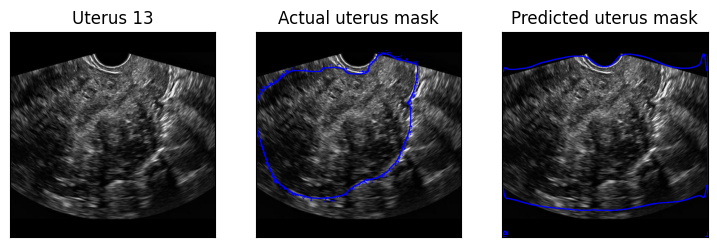

1/1 [==============================] - 0s 21ms/step


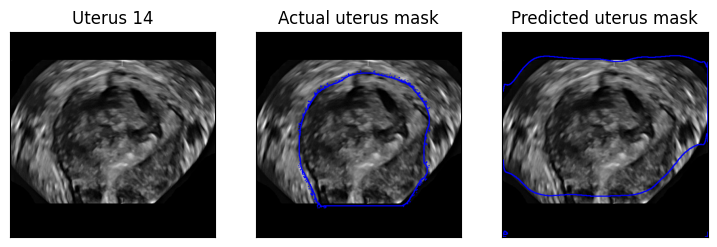

1/1 [==============================] - 0s 23ms/step


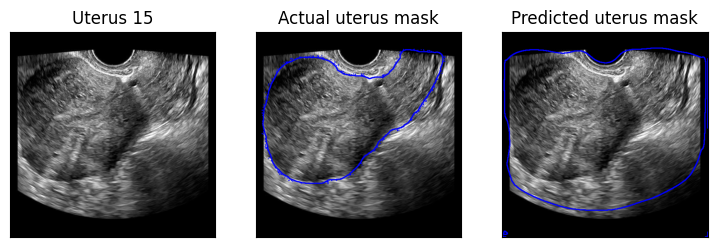

1/1 [==============================] - 0s 27ms/step


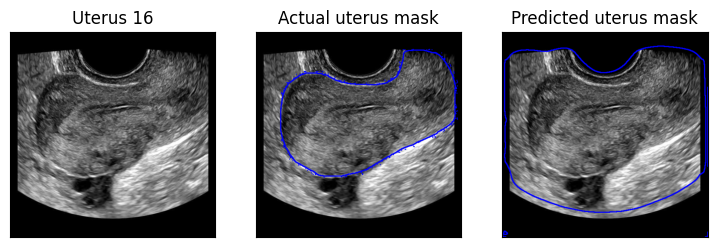

1/1 [==============================] - 0s 20ms/step


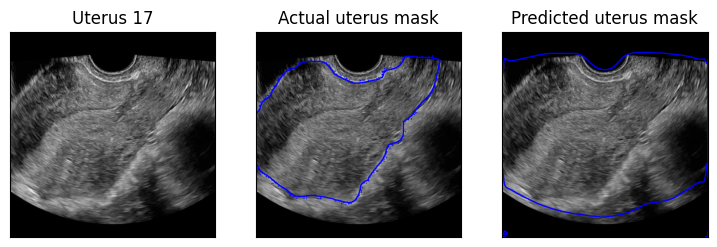

1/1 [==============================] - 0s 53ms/step


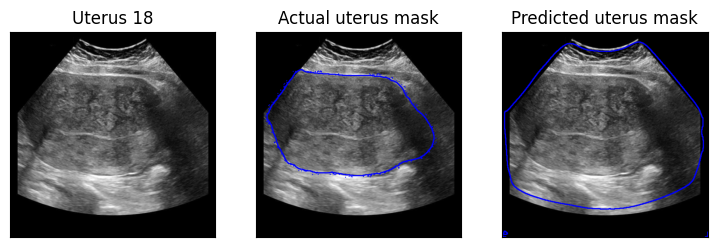

1/1 [==============================] - 0s 52ms/step


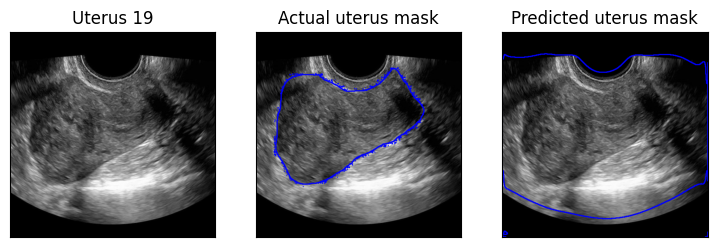

1/1 [==============================] - 0s 42ms/step


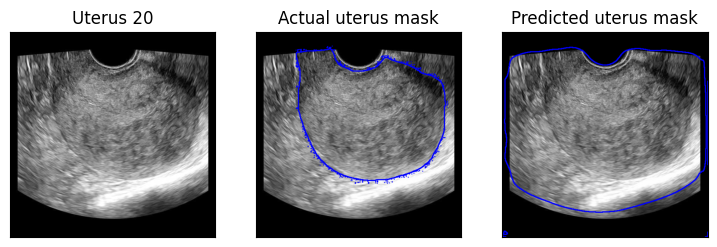

1/1 [==============================] - 0s 46ms/step


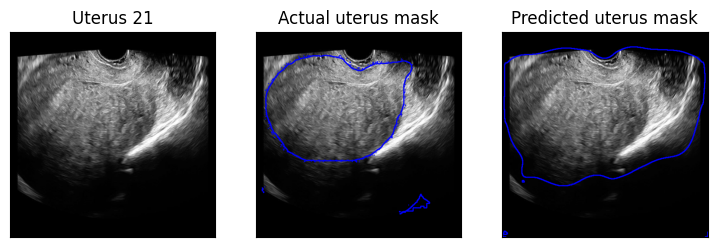

In [ ]:
for i in range(len(uterus_test)):
    uterus_img = uterus_test[i]
    actual_mask = uterus_mask_test[i]
    predicted_mask = model.predict(np.expand_dims(uterus_img, axis=0))[0]
    visualize_image_mask(uterus_img, draw_mask_outline(uterus_img, actual_mask), draw_mask_outline(uterus_img, predicted_mask), image_title=f"Uterus {i}", mask1_title="Actual uterus mask", mask2_title="Predicted uterus mask")